# 🍔 Fast Food Marketing Campaign — A/B Test


### 🎯 Goal & Scope

This analysis evaluates the effectiveness of three different promotional strategies used by a large fast-food chain across multiple markets.
The goal was to identify which promotion generated the highest sales, measured in thousands of dollars, while applying robust statistical testing to ensure significance.

The project practices experimental design, non-parametric hypothesis testing, and visual data storytelling.

### 🚰 Data Source
- Kaggle: https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import helper_functions as hf
import statsmodels.api as sm
import itertools

from scipy.stats import mannwhitneyu

In [2]:
df_raw = pd.read_csv('/Users/guywinfield/PycharmProjects/Data/Fast Food Campaign/WA_Marketing-Campaign.csv',index_col=False)

In [3]:
df_raw.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


Data Defintions
- `MarketID`: unique identifier for market
- `MarketSize`: size of market area by sales
- `LocationID`: unique identifier for store location
- `AgeOfStore`: age of store in years
- `Promotion`: one of three promotions that were tested
- `week`: one of four weeks when the promotions were run
- `SalesInThousands`: sales amount for a specific LocationID, Promotion, and week

In [4]:
df = df_raw.copy()

### Data Preparation

In [5]:
df.isna().sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

In [6]:
df.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


In [7]:
for col in [c for c in df.columns if c not in ['LocationID','SalesInThousands','AgeOfStore','week']]:
    print(f"\nColumn: {col}")
    print(df_raw[col].value_counts().sort_values())


Column: MarketID
MarketID
2     24
4     36
9     40
8     48
1     52
5     60
6     60
7     60
10    80
3     88
Name: count, dtype: int64

Column: MarketSize
MarketSize
Small      60
Large     168
Medium    320
Name: count, dtype: int64

Column: Promotion
Promotion
1    172
3    188
2    188
Name: count, dtype: int64


In [8]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


Text(0.5, 1.0, 'Density of Sales by Week')

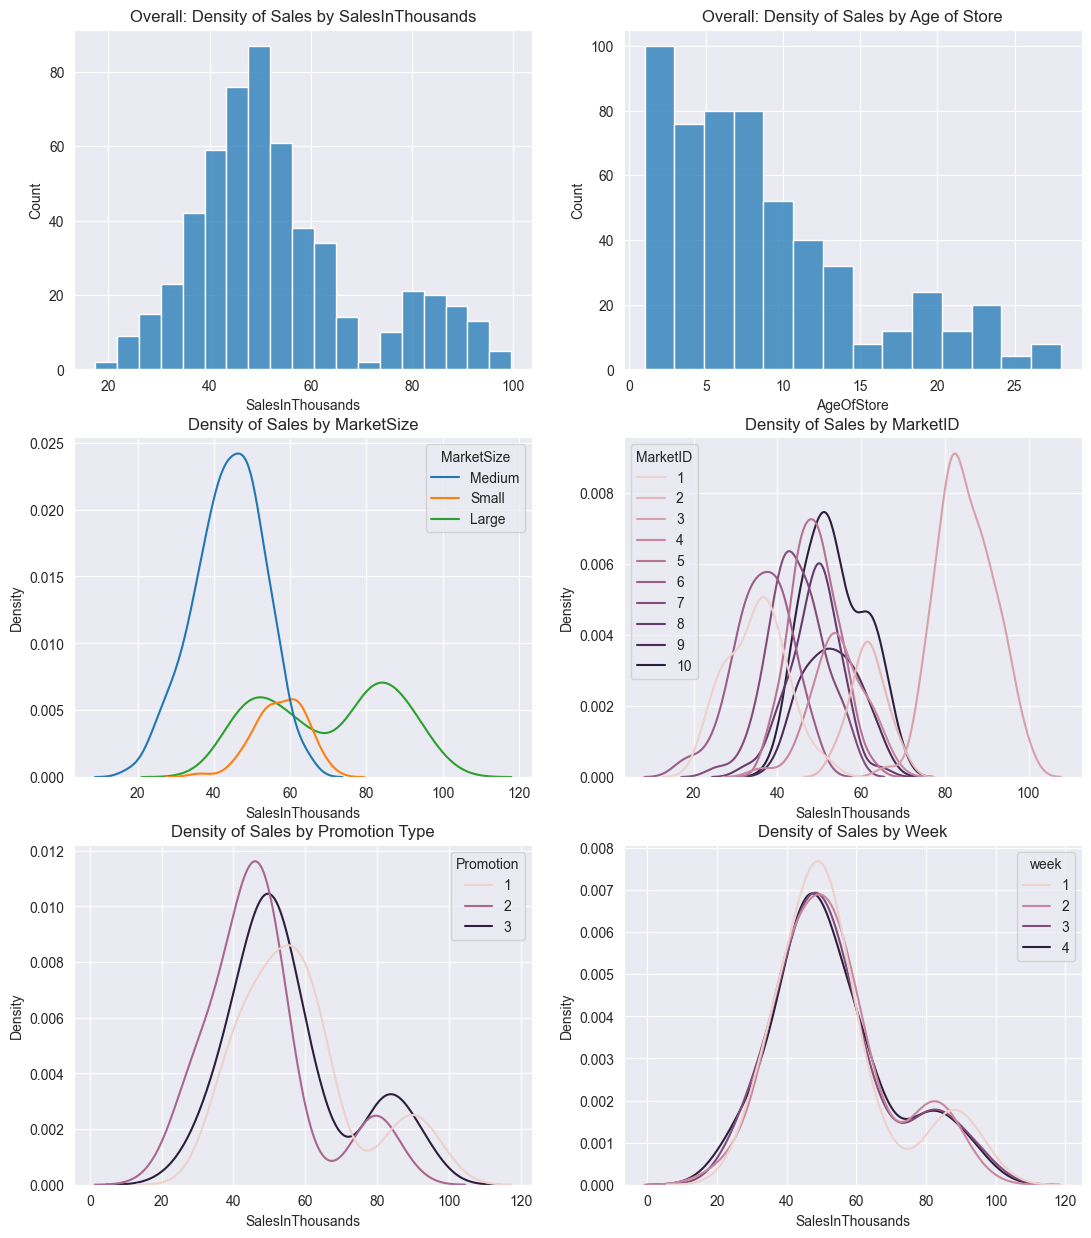

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(13, 15))

# --- Chart 1: Sales by MarketSize ---
sns.histplot(data=df, x='SalesInThousands', ax=ax[0,0]).set_title("Overall: Density of Sales by SalesInThousands")

# --- Chart 2: Sales by AgeofStore ---
sns.histplot(data=df, x='AgeOfStore', ax=ax[0,1]).set_title("Overall: Density of Sales by Age of Store")

# --- Chart 3: Sales by MarketSize ---
sns.kdeplot(data=df, x='SalesInThousands', hue='MarketSize', ax=ax[1,0]).set_title("Density of Sales by MarketSize")

# --- Chart 4: Sales by MarketSize ---
sns.kdeplot(data=df, x='SalesInThousands', hue='MarketID', ax=ax[1,1]).set_title("Density of Sales by MarketID")

# --- Chart 5: Sales by Promotion ---
sns.kdeplot(data=df, x='SalesInThousands', hue='Promotion', ax=ax[2,0]).set_title("Density of Sales by Promotion Type")

# --- Chart 6: Sales by Promotion ---
sns.kdeplot(data=df, x='SalesInThousands', hue='week', ax=ax[2,1]).set_title("Density of Sales by Week")

In [10]:

df_grouped = (
    df.groupby(["MarketID"])
      .agg(avg_sales=("SalesInThousands", "mean"))
)
df_grouped

,avg_sales
MarketID,
1,35.101731
2,61.761250
3,84.971705
4,54.508056
5,48.838000
6,36.397500
7,44.475333
8,48.952917
9,52.940750


<Axes: xlabel='SalesInThousands', ylabel='Density'>

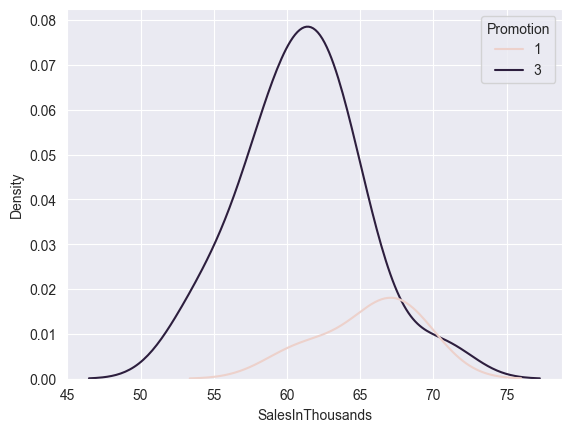

In [11]:
subset = df.loc[(df['MarketID'] == 2), ['Promotion', 'SalesInThousands']]

sns.kdeplot(data=subset,x='SalesInThousands',hue='Promotion')

## Choosing our target metric

 ### Primary metric: **Sales in Thousands**
Ultimately we want to increase sales via our promotions therefore we'll measure the mean Sales in Thousands as our primary metric to compare the success of each promotion.

Going forward we will use the **Sales in Thousands** as our primary metric. This gives us a clean and clear barometer of whether a promotion drove higher sales or not.


### Q-Q Plot

It’s a visual way to check whether your data follows a specific theoretical distribution. If our datapoints fall on a linear 45 degree line then we can safely say our distribution is approximately normal (Or even perfect if it falls on the line entirely!).

However, we can interpret the distribution not to be normal if either side of 0 on our x axis we see datapoints:
- Above the line: More data at high values (Right Skew)
- Below the line: More data at low values (Left Skew)

Looking at our Q-Q plot we can see a skew in high & low values


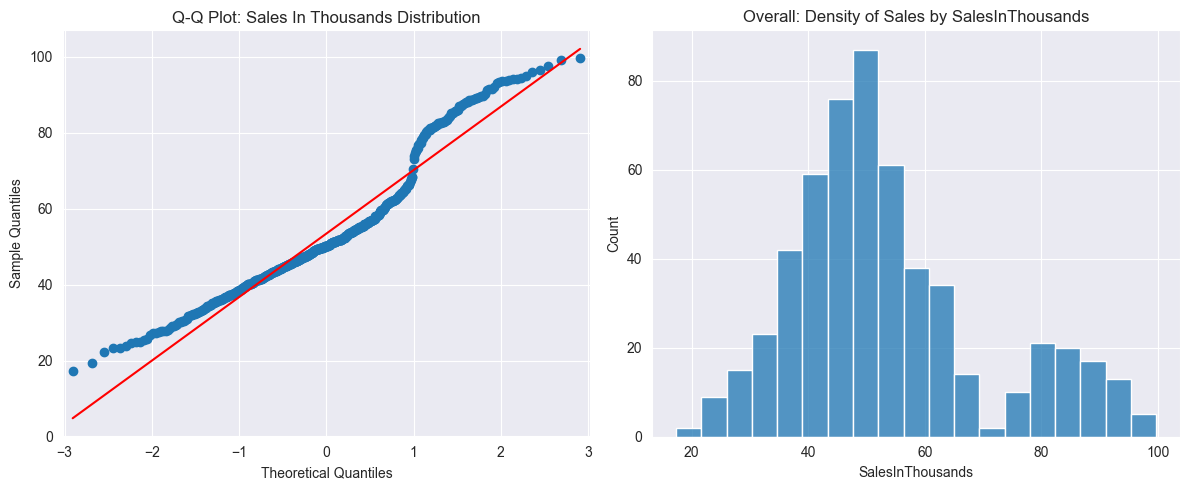

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sm.qqplot(df['SalesInThousands'], line='s', ax=ax[0])
ax[0].set_title("Q-Q Plot: Sales In Thousands Distribution")

sns.histplot(data=df, x='SalesInThousands', ax=ax[1])


ax[1].set_title("Overall: Density of Sales by SalesInThousands")

plt.tight_layout()
plt.show()



### Let's check to see if there is any difference between our Sales distributions by Promotion type
#### Kruskal–Wallis test

It compares the ranks of sales across the 3 promotions and tells you whether at least one group differs significantly.

It returns a :
- H statistic which tells you the average distance between the groups
- p-value which tells you how significant of a difference there is, we'll take 0.05 as our alpha

These results tell us there is a large difference between our groups but we don't know between which ones specifically. For that we'll have to do an additional test.

In [48]:
from scipy.stats import kruskal

stat, p = kruskal(df[df['Promotion']==1]['SalesInThousands'],
                  df[df['Promotion']==2]['SalesInThousands'],
                  df[df['Promotion']==3]['SalesInThousands'])

print(stat,  f'{p:.20f}')

53.29475169322799 0.00000000000267418663


We'll complement these measures with some U-tests to see where the biggest differences are between our groups

In [52]:
pd.set_option('display.float_format', lambda x: '%.8f' % x)

# U testing
groups = df['Promotion'].unique()
results = []

for g1, g2 in itertools.combinations(groups, 2):
    data1 = df.loc[df['Promotion'] == g1, 'SalesInThousands']
    data2 = df.loc[df['Promotion'] == g2, 'SalesInThousands']

    stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
    results.append((g1, g2, stat, p))

pairwise_df = pd.DataFrame(results, columns=['Group1', 'Group2', 'U_statistic', 'p_value'])
pairwise_df


,Group1,Group2,U_statistic,p_value
0,3,2,23251.00000000,0.00000012
1,3,1,14089.00000000,0.03508410
2,2,1,9378.50000000,0.00000000


### Approach
Looking at our previous 'Density of Sales by Promotion Type' chart we can see each promotion has a bi-modal distribution to the right. This could be for a number of reasons if we look at the other charts:
    - Market Sizes differ in Sales Volumes
    - Some older stores have higher sales, these could be extra large stores which have been around for longer

🚨 Caution 🚨: We have an outlier distribution looking at MarketID 1, we'll loop back to see if this skews our data in anyway.

Given that our SalesinThousands metric is not normally distributed we'll bootstrap our data so that we can compare a normal distribution of the re-sampled means, thanks to the Central Limit Theorem the distribution of the mean becomes approximately normal and from there we'll be able to evaluate the difference between promotion types. '

Text(0.5, 1.0, 'Distribution of Resampled Median Sales by Promotion')

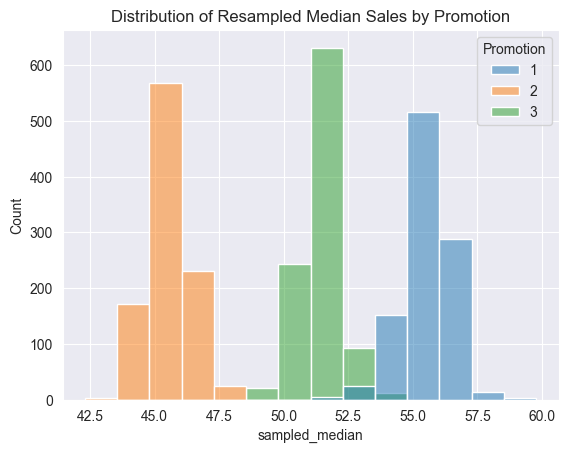

In [37]:
replications = 1000
promotions = [1, 2, 3]

pieces = []
for i in promotions:
    df_sample = df.loc[df['Promotion'] == i, ['SalesInThousands']]
    meds = hf.bootstrap_median(df_sample, 'SalesInThousands', replications)
    pieces.append(pd.DataFrame({'sampled_median': meds, 'Promotion': i}))

bootstrap_df = pd.concat(pieces, ignore_index=True)
bootstrap_df['Promotion'] = bootstrap_df['Promotion'].astype('category')

sns.histplot(data=bootstrap_df, x='sampled_median', hue='Promotion').set_title(f"Distribution of Resampled Median Sales by Promotion")



We can defintelty see very little overlap between our 3 promotion types like our Kruskal–Wallis test suggested. Let's round up our analysis by factoring plotting the Median SalesInThousands for each promotion with their respective Confidence Intervals.

*NOTE*: We're expecting very small Confidence Intervals as we re-sampled our data 1000 times in the bootstrapping. By increasing N we increase the sample size, which also leads to a smaller confidence interval. A larger sample size reduces the standard error (the variability of our estimate).


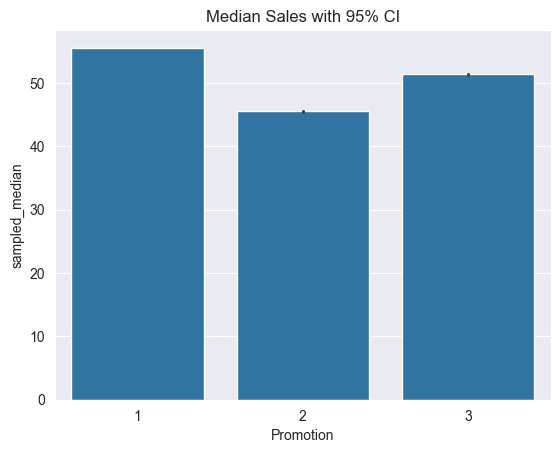

In [50]:
sns.barplot(data=bootstrap_df, x="Promotion", y="sampled_median", errorbar=('ci', 95), dodge=False)
plt.title("Median Sales with 95% CI")
plt.show()


### 🧾 Conclusion

Promotion 1 appears to be the most effective, showing the highest bootstrapped median sales value of 55k, followed by Promotion 3 (51k) and Promotion 2 (45k).

The differences between the promotions are **statistically significant** at the **α = 0.05** level. In particular, **Promotion 1’s confidence interval does not overlap** with those of the other promotions, suggesting it performed meaningfully better in generating sales.


In [62]:
bootstrap_df.groupby('Promotion').describe().T

/var/folders/kn/24kjgmss2yzfjngp_zf6x8vr0000gn/T/ipykernel_15608/77578827.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bootstrap_df.groupby('Promotion').describe().T


Promotion                        1             2             3
sampled_median count 1000.00000000 1000.00000000 1000.00000000
               mean    55.53236500   45.55112000   51.39070500
               std      0.99703325    0.84996287    0.78746707
               min     51.72000000   42.30500000   48.82500000
               25%     55.11500000   44.96000000   51.01000000
               50%     55.46000000   45.38500000   51.31250000
               75%     56.14500000   46.11000000   51.90000000
               max     59.77000000   48.32000000   54.68000000